# Copy of data exporting an proccessing Code
****



In [1]:
! pip install split-folders

import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders #(pip install split-folders)
import tensorflow as tf
import shutil
import urllib.request
import zipfile

## Downloading the database

# If you do not posess the AnimalFace.zip archive, this cells downloads it

if not os.path.exists('data'):
    os.makedirs('data/')
    
if not os.path.exists('data/images/') or len(os.listdir('data/images/')) == 0:
    if not os.path.exists('data/AnimalFace.zip'):
        url = 'https://vcla.stat.ucla.edu/people/zhangzhang-si/HiT/AnimalFace.zip'
        urllib.request.urlretrieve(url, 'data/AnimalFace.zip')
    with zipfile.ZipFile('data/AnimalFace.zip', 'r') as zip_ref:
        zip_ref.extractall('data/')
    os.rename('data/Image/', 'data/images/')

if os.path.exists('./data/images/Natural'):
    shutil.rmtree('./data/images/Natural')

# Download the zip and unzip in a folder named Images
# And we delete the Natural folder which contains only 8 images non related to AnimalFaces

## Chosing the categories for One Shot Learning

categories = os.listdir('data/images')
if os.path.exists('data/OneShotImages/'):
    oneshot_cats = sorted(os.listdir('data/OneShotImages/'))
    categories += oneshot_cats
categories = sorted([cat for cat in categories])
print(f'There are {len(categories)} different categories, which are:', categories, '\n', sep='\n')

if not os.path.exists('data/OneShotImages/'):
    np.random.seed(42)
    oneshot_cats = np.random.choice(len(categories), 5)
    oneshot_cats = [categories[num] for num in oneshot_cats]
print('The chosen categories for One-Shot Learning are:', oneshot_cats)

train_cats = list(set(categories) - set(oneshot_cats))

if not os.path.exists('data/OneShotImages/'):
    os.makedirs('data/OneShotImages/')
    for cat in oneshot_cats:
        shutil.move('data/images/' + cat, 'data/OneShotImages/' + cat)

## Separating the folders into train and test

IMAGES_PATH = 'data/images/'
IMAGES_OS_PATH = 'data/OneShotImages/'

splitfolders.fixed(IMAGES_OS_PATH, output='data/', seed=42, fixed=(1, 0, -1), group_prefix=None, move=False)
shutil.rmtree('data/val/')
os.rename('data/train/', 'data/train_os/')
os.rename('data/test/', 'data/test_os/')

splitfolders.ratio(IMAGES_PATH, output='data/', seed=42, ratio=(.8, .0, .2), group_prefix=None, move=False)
shutil.rmtree('data/val/')

## Visualization of the database

batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

There are 20 different categories, which are:
['BearHead', 'CatHead', 'ChickenHead', 'CowHead', 'DeerHead', 'DogHead', 'DuckHead', 'EagleHead', 'ElephantHead', 'HumanHead', 'LionHead', 'MonkeyHead', 'MouseHead', 'PandaHead', 'PigHead', 'PigeonHead', 'RabbitHead', 'SheepHead', 'TigerHead', 'WolfHead']


The chosen categories for One-Shot Learning are: ['DuckHead', 'WolfHead', 'PigHead', 'LionHead', 'EagleHead']


Copying files: 502 files [00:00, 2130.62 files/s]
Copying files: 1905 files [00:01, 1884.74 files/s]


# Start of Clip Code
****

In [4]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 53 kB 1.3 MB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-htgkd8q7
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-htgkd8q7
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=e4ff8575d2255ad59cbfaaed8b3800068a4a43a2f13d141047ba7cb374c224e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-rja57lg8/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [5]:
import time
import os
import copy

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import clip

## Training utils functions

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc.item())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
class model_classif(torch.nn.Module):
    def __init__(self,model,n_out,feature_extraction=True):
        super(model_classif, self).__init__()
        self.model_pretrained = model # The pretrained model

        set_parameter_requires_grad(self.model_pretrained,feature_extraction)
        self.fc = nn.Linear(self.model_pretrained.output_dim,n_out)  # The output layer we add
        self.gle = nn.GELU()  # The activation function

    def forward(self,x):
        res0=self.model_pretrained(x)
        res1=self.fc(res0)
        res2=self.gle(res1)

        return res2

## Get Data

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 120MiB/s]


In [ ]:
# Number of classes in the dataset
num_classes = 15

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params

data_dir = './data/'

In [ ]:
print("Initializing Datasets and Dataloaders...")


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), preprocess) for x in ['train', 'test']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

# Detect if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

Initializing Datasets and Dataloaders...
cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## First Model

In [ ]:
feature_extract = True

model_feat_extr_1 = model_classif(model.visual,n_out=num_classes,feature_extraction=feature_extract)
input_size = model.visual.input_resolution



model_feat_extr_1 = model_feat_extr_1.to(device).float()

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_feat_extr_1.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_feat_extr_1.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_feat_extr_1.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_feat_extr_1 = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_feat_extr_1, hist_feat_extr_1 = train_model(model_feat_extr_1, dataloaders_dict, criterion, optimizer_feat_extr_1, num_epochs=num_epochs)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8640 Acc: 0.9796
test Loss: 0.6251 Acc: 0.9764

Epoch 1/14
----------
train Loss: 0.4925 Acc: 0.9895
test Loss: 0.4038 Acc: 0.9869

Epoch 2/14
----------
train Loss: 0.3346 Acc: 0.9921
test Loss: 0.2976 Acc: 0.9895

Epoch 3/14
----------
train Loss: 0.2528 Acc: 0.9934
test Loss: 0.2362 Acc: 0.9921

Epoch 4/14
----------
train Loss: 0.2041 Acc: 0.9921
test Loss: 0.1958 Acc: 0.9895

Epoch 5/14
----------
train Loss: 0.1718 Acc: 0.9934
test Loss: 0.1705 Acc: 0.9921

Epoch 6/14
----------
train Loss: 0.1483 Acc: 0.9941
test Loss: 0.1508 Acc: 0.9921

Epoch 7/14
----------
train Loss: 0.1316 Acc: 0.9947
test Loss: 0.1364 Acc: 0.9921

Epoch 8/14
----------
train Loss: 0.1180 Acc: 0.9941
test Loss: 0.1243 Acc: 0.9921

Epoch 9/14
----------
train Loss: 0.1073 Acc: 0.9941
test Loss: 0.1150 Acc: 0.9921

Epoch 10/14
----------
train Loss: 0.0986 Acc: 0.9954
test Loss: 0.1075 Acc: 0.9921

Epoch 11/14
----------
train Loss: 0.0912 Acc: 0.9954
test Loss: 0.1006 Acc: 0.9921

Epoch 12/14


## Second Model

In [ ]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
feature_extract = False

model_ft_1 = model_classif(model.visual,n_out=num_classes,feature_extraction=feature_extract)
input_size = model.visual.input_resolution



model_ft_1 = model_ft_1.to(device).float()

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_1.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_1.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_1.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft_1 = optim.SGD(params_to_update, lr=1e-5, momentum=0.9)

Params to learn:
	 model_pretrained.class_embedding
	 model_pretrained.positional_embedding
	 model_pretrained.proj
	 model_pretrained.conv1.weight
	 model_pretrained.ln_pre.weight
	 model_pretrained.ln_pre.bias
	 model_pretrained.transformer.resblocks.0.attn.in_proj_weight
	 model_pretrained.transformer.resblocks.0.attn.in_proj_bias
	 model_pretrained.transformer.resblocks.0.attn.out_proj.weight
	 model_pretrained.transformer.resblocks.0.attn.out_proj.bias
	 model_pretrained.transformer.resblocks.0.ln_1.weight
	 model_pretrained.transformer.resblocks.0.ln_1.bias
	 model_pretrained.transformer.resblocks.0.mlp.c_fc.weight
	 model_pretrained.transformer.resblocks.0.mlp.c_fc.bias
	 model_pretrained.transformer.resblocks.0.mlp.c_proj.weight
	 model_pretrained.transformer.resblocks.0.mlp.c_proj.bias
	 model_pretrained.transformer.resblocks.0.ln_2.weight
	 model_pretrained.transformer.resblocks.0.ln_2.bias
	 model_pretrained.transformer.resblocks.1.attn.in_proj_weight
	 model_pretrained.tran

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft_1, hist_ft_1 = train_model(model_ft_1, dataloaders_dict, criterion, optimizer_ft_1, num_epochs=num_epochs)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.5660 Acc: 0.1803
test Loss: 2.3930 Acc: 0.2277

Epoch 1/14
----------
train Loss: 2.2253 Acc: 0.3092
test Loss: 2.0351 Acc: 0.4791

Epoch 2/14
----------
train Loss: 1.8158 Acc: 0.6684
test Loss: 1.6234 Acc: 0.7827

Epoch 3/14
----------
train Loss: 1.3962 Acc: 0.8724
test Loss: 1.2287 Acc: 0.9136

Epoch 4/14
----------
train Loss: 1.0271 Acc: 0.9539
test Loss: 0.9152 Acc: 0.9869

Epoch 5/14
----------
train Loss: 0.7499 Acc: 0.9934
test Loss: 0.6956 Acc: 0.9895

Epoch 6/14
----------
train Loss: 0.5610 Acc: 0.9980
test Loss: 0.5465 Acc: 0.9921

Epoch 7/14
----------
train Loss: 0.4321 Acc: 1.0000
test Loss: 0.4440 Acc: 0.9921

Epoch 8/14
----------
train Loss: 0.3437 Acc: 1.0000
test Loss: 0.3714 Acc: 0.9921

Epoch 9/14
----------
train Loss: 0.2811 Acc: 1.0000
test Loss: 0.3161 Acc: 0.9921

Epoch 10/14
----------
train Loss: 0.2355 Acc: 1.0000
test Loss: 0.2774 Acc: 0.9921

Epoch 11/14
----------
train Loss: 0.2017 Acc: 1.0000
test Loss: 0.2465 Acc: 0.9921

Epoch 12/14


## Plot Models Performance

In [ ]:
hist_feat_extr_1[0].item()

0.9764397905759163

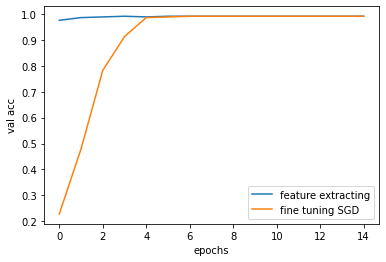

In [ ]:
fig=plt.figure()

plt.plot(range(15),hist_feat_extr_1,label='feature extracting')
plt.plot(range(15),hist_ft_1,label='fine tuning SGD')
plt.xlabel('epochs')
plt.ylabel('val acc')
plt.legend();

# One shot

In [59]:
print("Initializing Datasets and Dataloaders...")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model, preprocess = clip.load('ViT-B/32', device)

data_dir = './data/'

image_datasets_one_shot = datasets.ImageFolder(os.path.join(data_dir, "test_os"), preprocess)
dataloaders_one_shot  = torch.utils.data.DataLoader(image_datasets_one_shot, batch_size=1, shuffle=True, num_workers=4)

image_datasets_train_one_shot = datasets.ImageFolder(os.path.join(data_dir, "train_os"), preprocess)
dataloaders_train_one_shot  = torch.utils.data.DataLoader(image_datasets_one_shot, batch_size=1, shuffle=True, num_workers=4)

# Detect if the GPU is available

print(device)

Initializing Datasets and Dataloaders...
cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [69]:
image_datasets_train_one_shot = datasets.ImageFolder(os.path.join(data_dir, "train_os"), preprocess)
dataloaders_train_one_shot  = torch.utils.data.DataLoader(image_datasets_train_one_shot, batch_size=1, shuffle=False, num_workers=4)
# Calculate features
success = 0
nb_tot = 0



with torch.no_grad():
  train_features = torch.cat([model.encode_image(inputs.to(device)) for inputs, labels in dataloaders_train_one_shot])
  train_features /= train_features.norm(dim=-1, keepdim=True)

  for inputs, labels in dataloaders_one_shot:
    inputs = inputs.to(device)
    image_features = model.encode_image(inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ train_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)
    if indices.item() == labels.item():
      success += 1
    nb_tot += 1

accuracy = success/nb_tot
print(accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.9798792756539235


In [58]:
# Calculate features
success = 0
nb_tot = 0



with torch.no_grad():
  text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in oneshot_cats]).to(device)
  text_features = model.encode_text(text_inputs)
  text_features /= text_features.norm(dim=-1, keepdim=True)

  for inputs, labels in dataloaders_one_shot:
    inputs = inputs.to(device)
    image_features = model.encode_image(inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)
    if indices.item() == labels.item():
      success += 1
    nb_tot += 1

accuracy = success/nb_tot
print(accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.1851106639839034


In [55]:
print(accuracy)

0.0


In [49]:
oneshot_cats

['DuckHead', 'WolfHead', 'PigHead', 'LionHead', 'EagleHead']